The Quantum Approximate Optimization Algorithm (QAOA) is a promising algorithm for solving combinatorial optimization problems (COPs), with performance governed by variational parameters $\{\gamma_i, \beta_i\}_{i=0}^{p-1}$. 

While most prior work has focused on classically optimizing these parameters, we demonstrate that fixed linear ramp schedules—**linear ramp QAOA (LR-QAOA)**—can efficiently approximate optimal solutions across diverse COPs.

Simulations with up to \(N_q = 42\) qubits and \(p = 400\) layers suggest that the success probability scales as:

$$
P(x^*) \approx 2^{-\eta(p) N_q - C},
$$

where \(\eta(p)\) decreases with increasing \(p\). For example, in Weighted MaxCut instances, \(\eta(10) = 0.22\) improves to \(\eta(100) = 0.05\).

Comparisons with classical algorithms, including **simulated annealing**, **Tabu Search**, and **branch-and-bound**, show a scaling advantage for LR-QAOA.

We present LR-QAOA results on multiple QPUs (IonQ, Quantinuum, IBM) with up to \(N_q = 109\) qubits, \(p = 100\), and circuits requiring **21,200 CNOT gates**.

Finally, we introduce a **noise model based on two-qubit gate counts** that accurately reproduces the experimental behavior of LR-QAOA.


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import networkx as nx
from collections import defaultdict
from scipy.optimize import minimize

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 0.8
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
cm_colors = plt.get_cmap('Set2')


In [20]:
# def fit_eta(x, nqs, y_real):
#     eta = x[0]
#     y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
#     return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2

def fit_eta(x, nqs, y_real):
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq) + C  for nq in nqs])
    return ((y_eff - y_real)**2).mean()

def eta_func(nqs, eta, C):
    return np.array([-eta*(nq) + C  for nq in nqs])

In [365]:
problems = ["WMaxcut", "PO", "MIS","3Maxcut"]
results = {problem: np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item() for problem in problems}
quartile = 2
averages = {}
for problem in problems:
    average = defaultdict(dict)
    for i, p in enumerate([10,25,50,100,200]):
        for nq in sorted(results[problem].keys()):
            y = [results[problem][nq][kk]["best"][p]["probabiliy"] for kk in results[problem][nq].keys()]
            quartiles = np.percentile(np.array(y), [25, 50, 75])
            average[p][nq] = quartiles[quartile]
    averages[problem] = average

np.save(f"./Data/Q{quartile}.npy", averages)

In [209]:
ps = [10,25,50,100,200]
etas = {}
error = {}
cs = {}
QS = ["Q0","Q1","Q2"]
problems = ["WMaxcut", "PO", "MIS","3Maxcut"]
for i, problem in enumerate(problems):
    etas[problem] = {}
    error[problem] = {}
    cs[problem] = {}
    for Q in QS:
        averages = np.load(f"./Data/{Q}.npy", allow_pickle=True).item()
        etas[problem][Q] = defaultdict(dict)
        cs[problem][Q] = defaultdict(dict)
        error[problem][Q] = defaultdict(dict)
        sort = averages[problem]
        for p in ps:
            nqs = list(averages[problem][p].keys())[:-1]
            for min_q in nqs[:-3]:
                nqs = [q for q in  nqs if q > min_q] 
                # y_real = np.array([np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs])
                y_real = np.array([np.log2(sort[p][nq]) for nq in nqs])
                x0 = [0.25, 0.05]
                sol = minimize(fit_eta, x0, args=(nqs, y_real))
                etas[problem][Q][min_q][p] = sol.x[0]
                cs[problem][Q][min_q][p] = sol.x[1]
                p_real = np.array([sort[p][nq] for nq in nqs])
                # error[problem][Q][min_q][p] = (np.abs(np.array([sort[p][nqs[0]] * 2**(-sol.x[0]*(nq - nqs[0])) for nq in nqs]) - p_real)/p_real).mean()
                error[problem][Q][min_q][p] = (np.abs(np.array([2**(-sol.x[0]*(nq) + sol.x[1]) for nq in nqs]) - p_real)/p_real).mean()

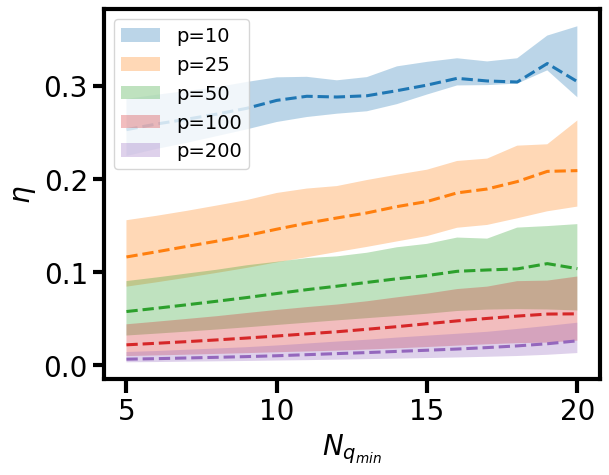

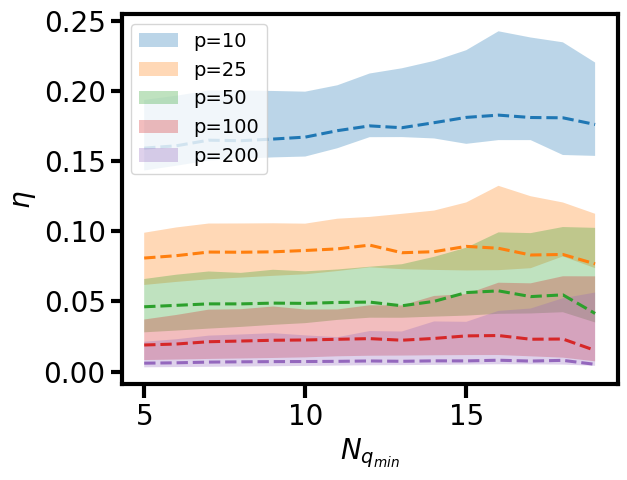

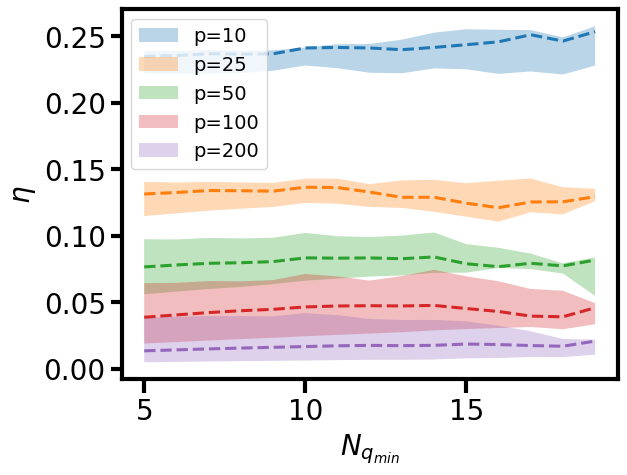

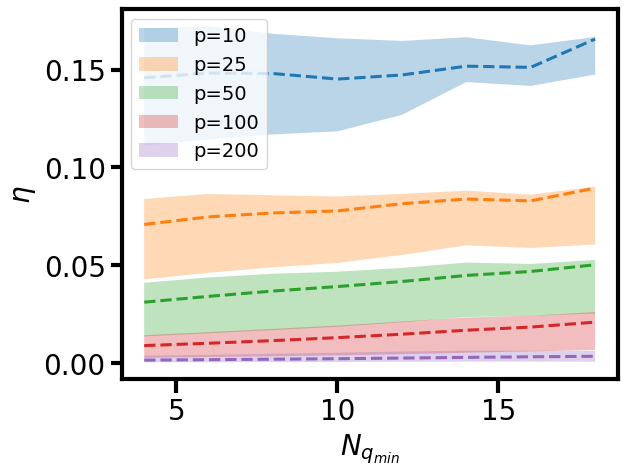

In [212]:
problem = "PO"
for problem in ["MIS", "PO", "WMaxcut", "3Maxcut"]:
    min_qs = list(etas[problem]["Q1"].keys())
    fig, ax = plt.subplots()
    for p in ps:
        y = np.array([[etas[problem][Q][q][p] for Q in QS] for q in min_qs])
        ax.plot(min_qs, np.median(y, axis=1), linestyle="--")
        ax.fill_between(min_qs, y.min(axis=1), y.max(axis=1), alpha=0.3, label=f"p={p}")
    ax.legend(loc=2)
    ax.set_xlabel(r"$N_{q_{min}}$")
    ax.set_ylabel(r"$\eta$")

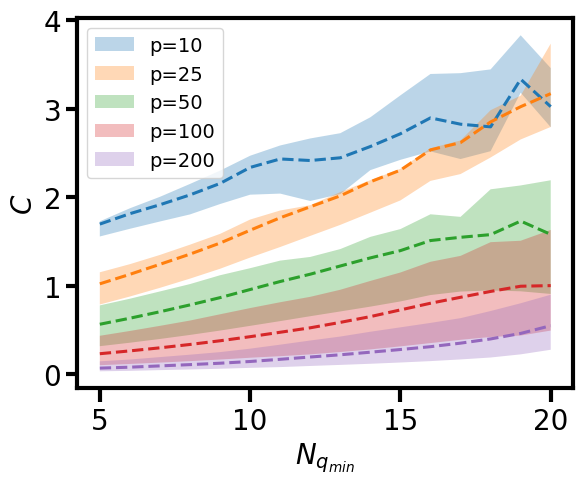

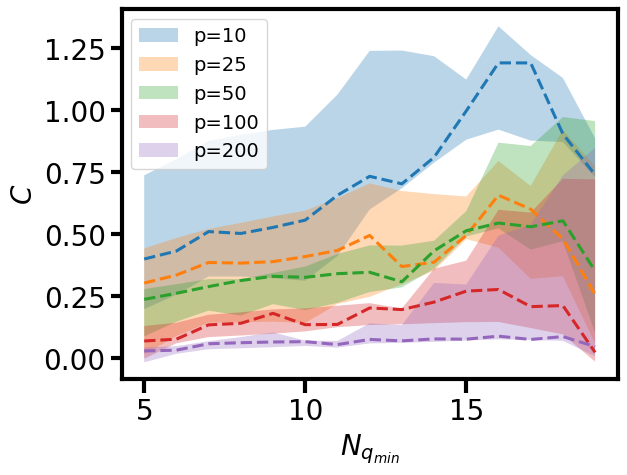

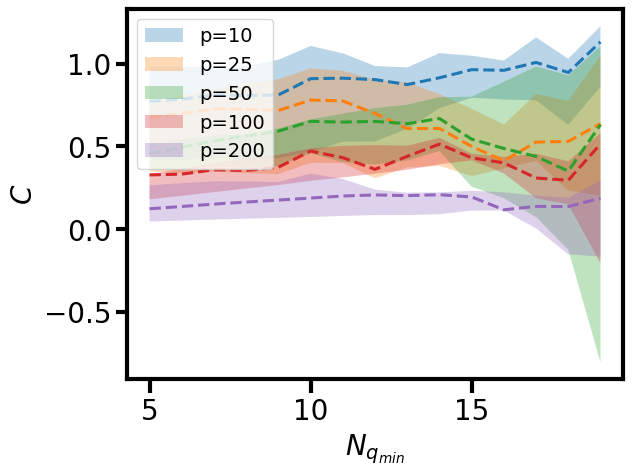

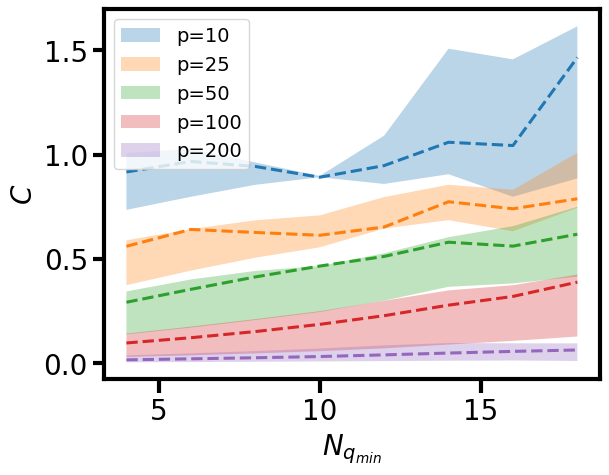

In [213]:
problem = "PO"
for problem in ["MIS", "PO", "WMaxcut", "3Maxcut"]:
    min_qs = list(etas[problem]["Q1"].keys())
    fig, ax = plt.subplots()
    for p in ps:
        y = np.array([[cs[problem][Q][q][p] for Q in QS] for q in min_qs])
        ax.plot(min_qs, np.median(y, axis=1), linestyle="--")
        ax.fill_between(min_qs, y.min(axis=1), y.max(axis=1), alpha=0.3, label=f"p={p}")
    ax.legend(loc=2)
    ax.set_xlabel(r"$N_{q_{min}}$")
    ax.set_ylabel(r"$C$")
    # fig.savefig(f"./Figures/{problem}_eta_predicted_Nq.pdf", bbox_inches="tight", transparent=True)

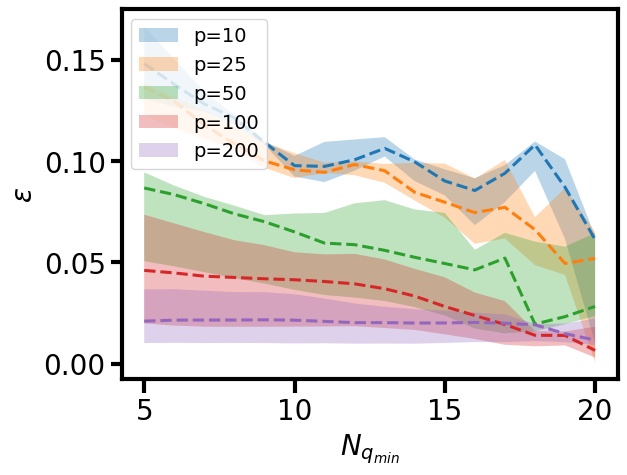

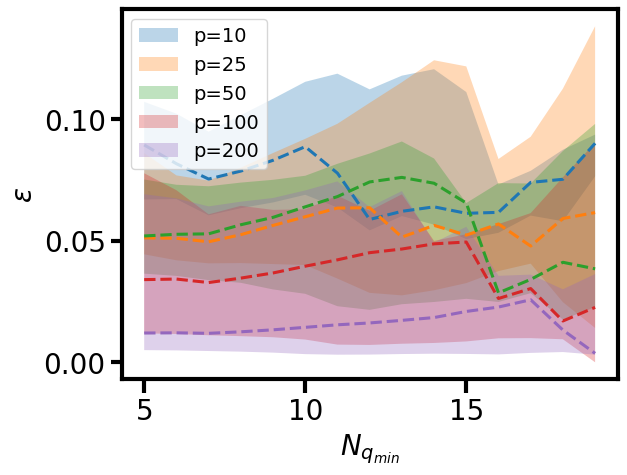

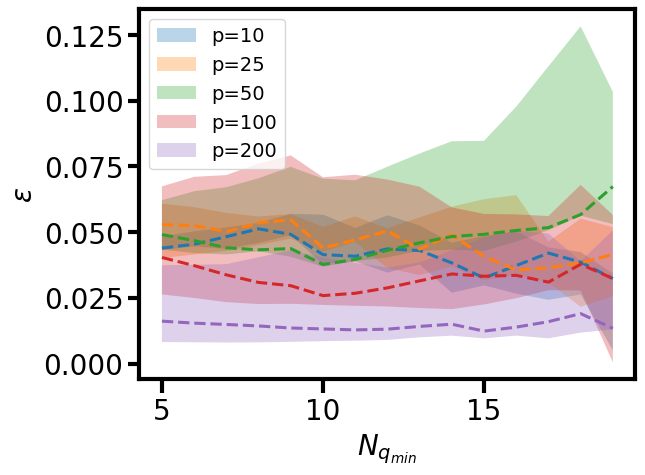

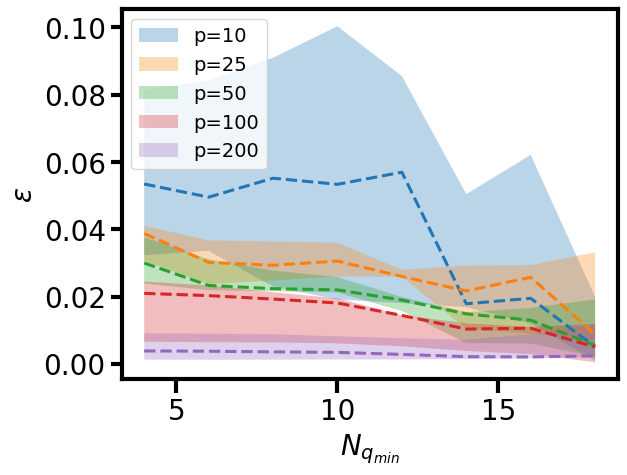

In [214]:
problem = "PO"
for problem in ["MIS", "PO", "WMaxcut", "3Maxcut"]:
    min_qs = list(error[problem]["Q1"].keys())
    fig, ax = plt.subplots()
    QS = ["Q0","Q1","Q2"]
    for p in ps:
        y = np.array([[error[problem][Q][q][p] for Q in QS] for q in min_qs])
        ax.plot(min_qs, np.median(y, axis=1), linestyle="--")
        ax.fill_between(min_qs, y.min(axis=1), y.max(axis=1), alpha=0.3, label=f"p={p}")
    ax.legend(loc=2)
    ax.set_xlabel(r"$N_{q_{min}}$")
    ax.set_ylabel(r"$\epsilon$")
    fig.savefig(f"./Figures/{problem}_error_predicted_Nq.pdf", bbox_inches="tight", transparent=True)

problem:WMaxcut, eta:0.22949048684991333, C:0.6941794179724203, p:10
problem:WMaxcut, eta:0.12497470435240686, C:0.5100233601207929, p:25
problem:WMaxcut, eta:0.07925056403805256, C:0.5496759501678963, p:50
problem:WMaxcut, eta:0.057056220109263575, C:0.6826950762651646, p:100
problem:WMaxcut, eta:0.031327309309437446, C:0.4769944563812293, p:200
problem:PO, eta:0.18046538489101596, C:0.8657605481541851, p:10
problem:PO, eta:0.08829769673515145, C:0.46144079084991607, p:25
problem:PO, eta:0.05031594797070846, C:0.3987444768831675, p:50
problem:PO, eta:0.023976993577877647, C:0.24255451822230586, p:100
problem:PO, eta:0.007546406372580441, C:0.07572723565539968, p:200
problem:MIS, eta:0.3156160157398422, C:3.0027821008627047, p:10
problem:MIS, eta:0.183711580803664, C:2.458013512689434, p:25
problem:MIS, eta:0.09821614068258733, C:1.4338543805369048, p:50
problem:MIS, eta:0.04931672627618002, C:0.8183678904978987, p:100
problem:MIS, eta:0.01891877851812438, C:0.33354863772669435, p:200


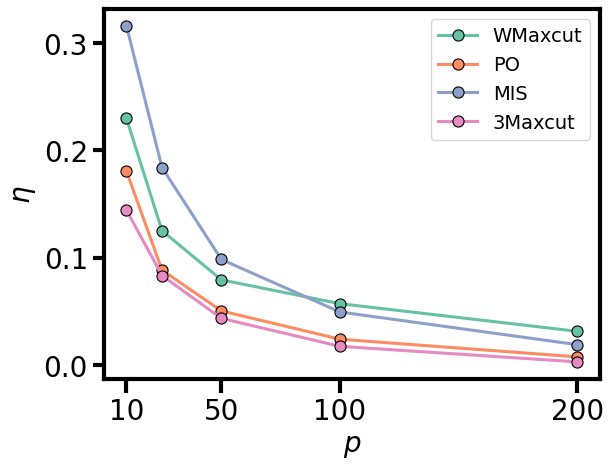

In [17]:
averages = np.load("./Data/Q1.npy", allow_pickle=True).item()
colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
min_q = 15
fig, ax = plt.subplots()
for i, problem in enumerate(averages.keys()):
    etas = {}
    error = {}
    sort = averages[problem]
    for p in ps:
        nqs = [q for q in list(averages[problem][p].keys()) if q > min_q] 
        # y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
        y_real = [np.log2(sort[p][nq]) for nq in nqs]
        x0 = [0.25, 0.5]
        sol = minimize(fit_eta, x0, args=(nqs, y_real))
        etas[p] = sol.x[0]
        p_real = np.array([sort[p][nq] for nq in nqs])
        error[p] = (np.abs(np.array([2**(-sol.x[0]*(nq) + sol.x[1]) for nq in nqs]) - p_real)/p_real).mean()
        print(f"problem:{problem}, eta:{etas[p]}, C:{sol.x[1]}, p:{p}")
    ax.plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", markersize=8, markeredgecolor="black", label=problem, color=colors(i))
    ax.set_ylabel(r"$\eta$")
    ax.set_xlabel(r"$p$")
ax.legend()
# ax.set_yscale("log")
ax.set_xticks([10,50,100,200])
# fig.savefig("./Figures/etas.pdf", transparent=True, bbox_inches="tight")

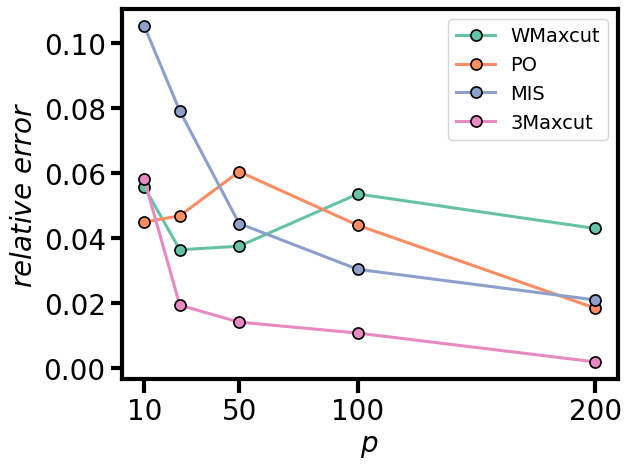

In [216]:
averages = np.load("./Data/Q1.npy", allow_pickle=True).item()
colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
min_q = 15
fig, ax = plt.subplots()
for i, problem in enumerate(averages.keys()):
    etas = {}
    error = {}
    sort = averages[problem]
    for p in ps:
        nqs = [q for q in list(averages[problem][p].keys()) if q > min_q] 
        # y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
        y_real = [np.log2(sort[p][nq]) for nq in nqs]
        x0 = [0.25, 0.5]
        sol = minimize(fit_eta, x0, args=(nqs, y_real))
        etas[p] = sol.x[0]
        p_real = np.array([sort[p][nq] for nq in nqs])
        error[p] = (np.abs(np.array([2**(-sol.x[0]*(nq) + sol.x[1]) for nq in nqs]) - p_real)/p_real).mean()

    ax.plot(sorted(ps), [error[p] for p in sorted(ps)], marker="o", markersize=8, markeredgecolor="black", label=problem, color=colors(i))
    ax.set_ylabel(r"$ relative \ error$")
    ax.set_xlabel(r"$p$")
ax.legend()
# ax.set_yscale("log")
ax.set_xticks([10,50,100,200])
fig.savefig("./Figures/error.pdf", transparent=True, bbox_inches="tight")

MIS 8.321797124656613e-09 10
MIS 0.4597807107302027 200
PO 1.1602009464987369e-05 10
PO 0.6358058167251126 200
WMaxcut 1.9736881934949305e-07 10
WMaxcut 0.21909348796777736 200
3Maxcut 8.694463319896777e-05 10
3Maxcut 0.8768422355063625 200


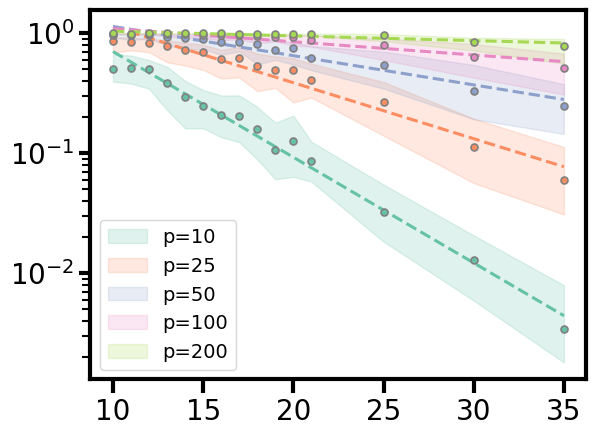

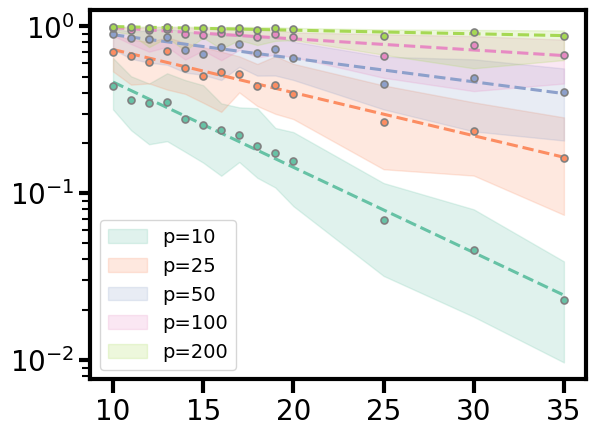

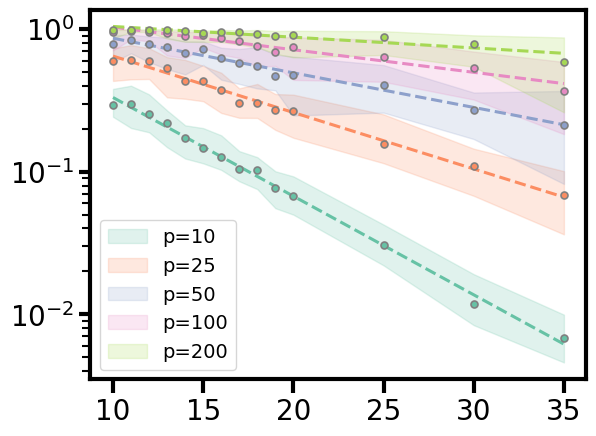

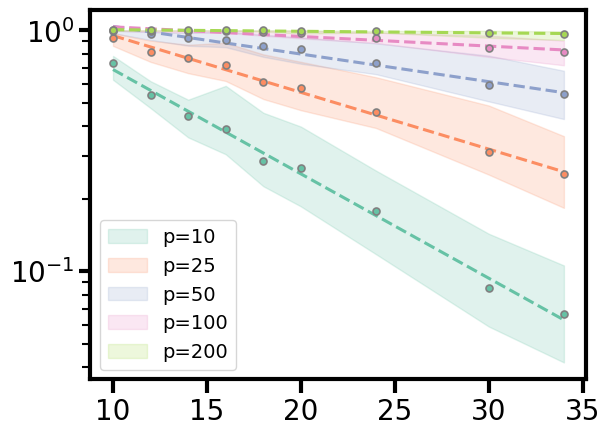

In [398]:
problem_name = "MIS"
for problem_name in ["MIS", "PO", "WMaxcut", "3Maxcut"]:
    colors = plt.get_cmap("Set2")
    sort = np.load("./Data/Q1.npy", allow_pickle=True).item()[problem_name]
    Q1 = np.load("./Data/Q0.npy", allow_pickle=True).item()[problem_name]
    Q3 = np.load("./Data/Q2.npy", allow_pickle=True).item()[problem_name]
    min_q = 10
    ps = [10,25,50,100,200]
    etas = {}
    Cs = {}
    error = {}
    for p in ps:
        nqs = [q for q in list(sort[p].keys()) if q >= min_q]
        y_real = [np.log2(sort[p][nq]) for nq in nqs]
        x0 = [0.25, 0.5]
        sol = minimize(fit_eta, x0, args=(nqs, y_real))
        etas[p] = sol.x[0]
        Cs[p] = sol.x[1]
        error[p] = sol.fun

    ps = [10,25,50,100,200]
    fig, ax = plt.subplots()
    for i, p in enumerate(sort.keys()):
        nqs = [q for q in list(sort[p].keys()) if q >= min_q]
        ax.plot(nqs, [2**(-etas[p]*(nq) + Cs[p]) for nq in nqs], linestyle="--", color=colors(i))
        ax.plot(nqs, [sort[p][nq] for nq in nqs], marker="o", linewidth=0, color=colors(i), markeredgecolor="gray")
        ax.fill_between(nqs, [Q1[p][nq] for nq in nqs], [Q3[p][nq] for nq in nqs], alpha=0.2, color=colors(i), label=f"p={p}")
        # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))
    print(problem_name, 2**(-etas[10]*(100) + Cs[10]), 10)
    print(problem_name, 2**(-etas[200]*(100) + Cs[200]), 200)

    ax.set_yscale("log")
    # ax.set_ylabel(r"$probability(x^*)$")
    # ax.set_xlabel(r"$N_q$")
    ax.set_xticks([10, 15,20,25,30,35])
    ax.legend()
    fig.savefig(f"./Figures/{problem_name}_scale.pdf", transparent=True, bbox_inches="tight")

# $\Delta_{\gamma}$ and $\Delta_{\beta}$ used 

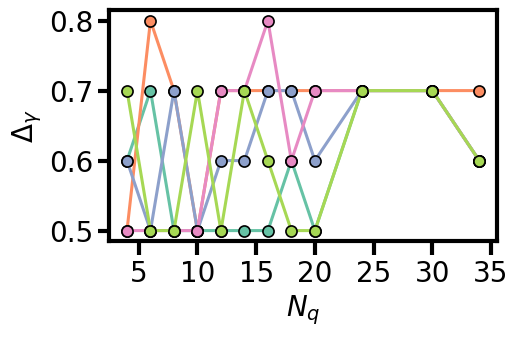

In [217]:
problem = "3MaxCut"
results = np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item()
max_ws = np.load("./Data/MIS/max_w.npy", allow_pickle=True).item()
problems = np.load(f"./Data/{problem}/problems.npy", allow_pickle=True).item()

kk = 0
fig, ax = plt.subplots(figsize=(5,3))
for i, p in enumerate(ps):
    if problem == "MIS":
        ax.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"]/(max_ws[nq]/0.5) for nq in sorted(results.keys())], marker="o", label=p, color=colors(i),markersize=8, markeredgecolor="black")
    else:
        ax.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i),markersize=8, markeredgecolor="black")
     
# ax.legend()
ax.set_ylabel(r"$\Delta_\gamma$")
ax.set_xlabel("$N_q$")
ax.set_xticks([5,10,15,20,25,30,35])
fig.savefig(f"./Figures/{problem}_delta_gamma.pdf", bbox_inches="tight", transparent=True)

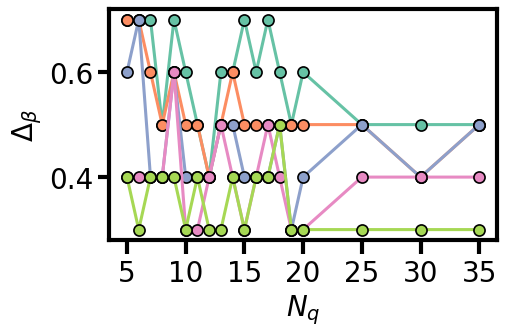

In [212]:
results = np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item()
kk = 0
fig, ax = plt.subplots(figsize=(5,3))
for i, p in enumerate(ps):
    ax.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_beta"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i),markersize=8, markeredgecolor="black")
# ax.legend()
ax.set_ylabel(r"$\Delta_\beta$")
ax.set_xlabel("$N_q$")
ax.set_xticks([5,10,15,20,25,30,35])
fig.savefig(f"./Figures/{problem}_delta_beta.pdf", bbox_inches="tight", transparent=True)

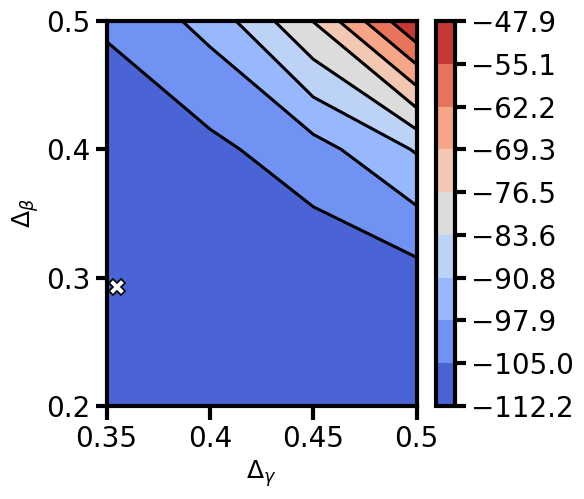

In [314]:
problem = "PO"
results = np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item()
gammas = [0.35,0.4,0.45,0.5]
betas = [0.2,0.3,0.4,0.5]

nq = 35
p = 200

kk = 0
X, Y = np.meshgrid(gammas, betas)
Z = results[nq][kk]["landscape"][p]["energy"]

fig, ax = plt.subplots(figsize=(5,5))
levels = np.round(np.linspace(np.min(Z), np.max(Z),10),1)
norm = cm.colors.Normalize( vmin=np.min(Z),vmax=np.max(Z))
cmap = cm.coolwarm
cset1 = ax.contourf(X, Y, Z, levels, norm=norm,
                        cmap="coolwarm")
cset2 = ax.contour(X, Y, Z, cset1.levels, colors='k')
cset2.set_linestyle('solid')
cset3 = ax.contour(X, Y, Z, (0,), colors='g', linewidths=1)
colorbar = fig.colorbar(cset1, ax=ax)
ax.plot(results[nq][kk]["best"][p]["delta_gamma"]+0.005, results[nq][kk]["best"][p]["delta_beta"]-0.007, marker="X", markeredgecolor="black", markersize=12, color="white")
ax.set_xlabel(r"$\Delta_\gamma$", fontsize=18)
ax.set_ylabel(r"$\Delta_\beta$", fontsize=18)
ax.set_xticks(gammas)
ax.set_yticks(betas)
ax.set_xticklabels(gammas)
ax.set_yticklabels(betas)
fig.savefig(f"./Figures/Landscape/energy_{problem}_nq{nq}_p{p}.pdf", bbox_inches="tight", transparent=True)



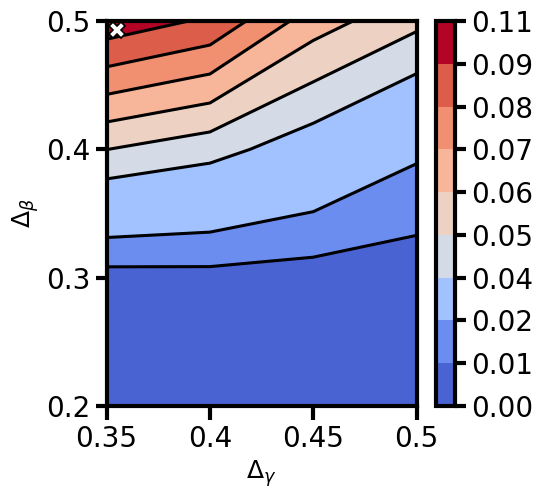

In [318]:
problem = "PO"
results = np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item()
gammas = [0.35,0.4,0.45,0.5]
betas = [0.2,0.3,0.4,0.5]

nq = 35
p = 10

X, Y = np.meshgrid(gammas, betas)
Z = results[nq][0]["landscape"][p]["probability"]

fig, ax = plt.subplots(figsize=(5,5))
# levels = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]
levels = np.round(np.linspace(np.min(Z), np.max(Z)+0.01, 10),2)
norm = cm.colors.Normalize( vmin=np.min(Z),vmax=np.max(Z))
cset1 = ax.contourf(X, Y, Z, levels, norm=norm,
                        cmap="coolwarm")
cset2 = ax.contour(X, Y, Z, cset1.levels, colors='k')
cset2.set_linestyle('solid')
cset3 = ax.contour(X, Y, Z, (0,), colors='g', linewidths=1)
colorbar = fig.colorbar(cset1, ax=ax)

ax.plot(results[nq][kk]["best"][p]["delta_gamma"]+0.005, results[nq][kk]["best"][p]["delta_beta"]-0.007, marker="X", markeredgecolor="black", markersize=12, color="white")

ax.set_xlabel(r"$\Delta_\gamma$", fontsize=18)
ax.set_ylabel(r"$\Delta_\beta$", fontsize=18)
ax.set_xticks(gammas)
ax.set_yticks(betas)
ax.set_xticklabels(gammas)
ax.set_yticklabels(betas)
fig.savefig(f"./Figures/Landscape/probability_{problem}_nq{nq}_p{p}.pdf", bbox_inches="tight", transparent=True)



Correlation:0.45056667552652996
Correlation:0.26463435693543286
Correlation:0.5917722820225954
Correlation:0.5663534576355432


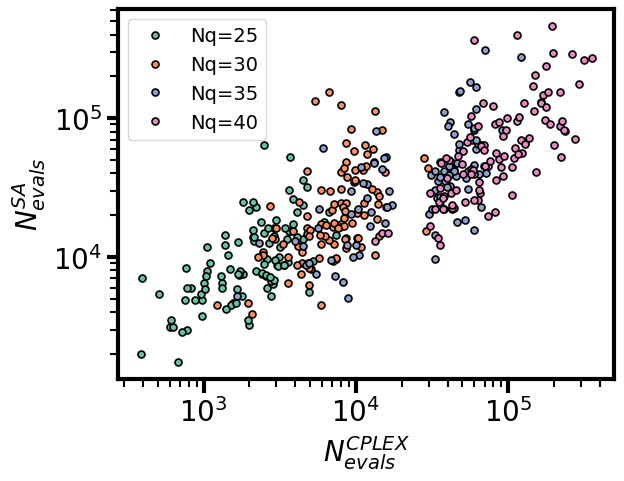

In [605]:
nq = 40
p = 5
colors= plt.get_cmap("Set2")
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
fig, ax = plt.subplots()
for i, nq in enumerate([25,30,35,40]):
    x = [results_sa[nq][kk]["n_iterations_cplex"] for kk in results_sa[nq].keys()]
    y = [nq*p*results_sa[nq][kk]["SA"][p]["STS"] for kk in results_sa[nq].keys()]
    ax.plot(x, y, marker="o", linewidth=0, markeredgecolor="black", color=colors(i), label=f"Nq={nq}")
    print(f"Correlation:{np.corrcoef(x,y)[0,1]}")
ax.set_xlabel(r"$N^{CPLEX}_{evals}$")
ax.set_ylabel(r"$N^{SA}_{evals}$")


ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/SA_vs_CPLEX.pdf", bbox_inches="tight", transparent=True)

Correlation : 20 : 0.1050580892281924
Correlation : 25 : 0.6266183938570692
Correlation : 30 : 0.3630116617086603
Correlation : 35 : 0.631143230067643
Correlation : 40 : 0.5886679274568848
Correlation Mean : 0.4628998604636899


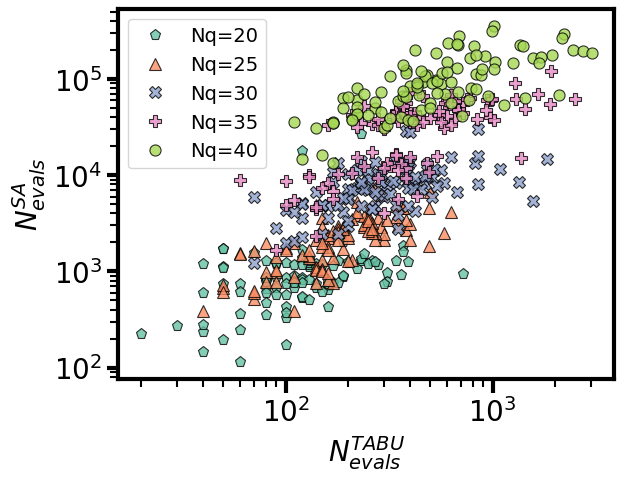

In [973]:
nq = 40
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
markers = {20:"p", 25:"^", 30:"X", 35:"P", 40:"o"}
fig, ax = plt.subplots()
sweeps = 10
iters = 10
PCC = []
for i, nq in enumerate([20,25,30,35,40]):
    y = [results_sa[nq][kk]["n_iterations_cplex"]for kk in results_sa[nq].keys()]
    x = [iters*results_tabu[nq][kk]["TABU"][iters]["STS"] for kk in results_tabu[nq].keys()]
    ax.plot(x, y, linewidth=0, markeredgecolor="black", color=colors(i), label=f"Nq={nq}", marker=markers[nq], markersize=8, alpha=0.8)
    PCC.append(np.corrcoef(x,y)[0,1])
    print(f"Correlation : {nq} : {np.corrcoef(x,y)[0,1]}")
ax.set_xlabel(r"$N^{TABU}_{evals}$")
ax.set_ylabel(r"$N^{SA}_{evals}$")
print(f"Correlation Mean : {np.mean(PCC)}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/CPLEX_vs_TABU.pdf", bbox_inches="tight", transparent=True)

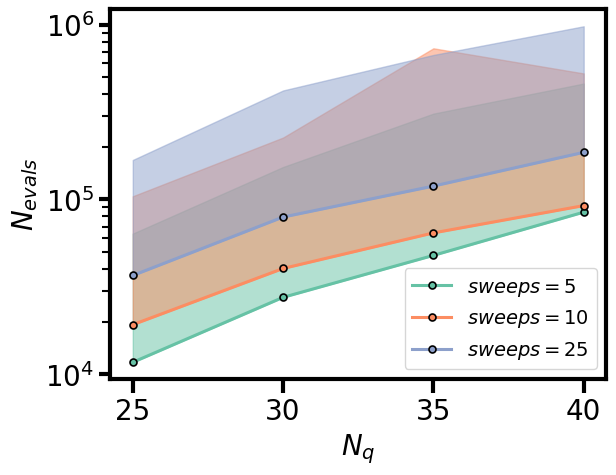

In [506]:
nq = 40
colors= plt.get_cmap("Set2")
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()

fig, ax = plt.subplots()
nqs = [25,30,35,40]
sweeps = [5,10,25]
for i, p in enumerate(sweeps):
    y = [np.mean([nq*p*results_sa[nq][kk]["SA"][p]["STS"] for kk in results_sa[nq].keys()]) for nq in nqs]
    y_max = [np.max([nq*p*results_sa[nq][kk]["SA"][p]["STS"] for kk in results_sa[nq].keys()]) for nq in nqs]
    ax.fill_between(nqs, y, y_max, color=colors(i), alpha=0.5)
    ax.plot(nqs, y, marker="o", markeredgecolor="black", color=colors(i), label=r"$sweeps=$"+f"{p}")

    # y = [np.mean([nq*p*results_tabu[nq][kk]["TABU"][p]["STS"] for kk in results_tabu[nq].keys()]) for nq in nqs]
    # ax.plot(nqs, y, marker="o", markeredgecolor="black", color=colors(i), label=f"TABU p={p}")
    ax.set_ylabel(r"$N_{evals}$")
    ax.set_xlabel(r"$N_q$")

ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/FC_SA.pdf", bbox_inches="tight", transparent=True)

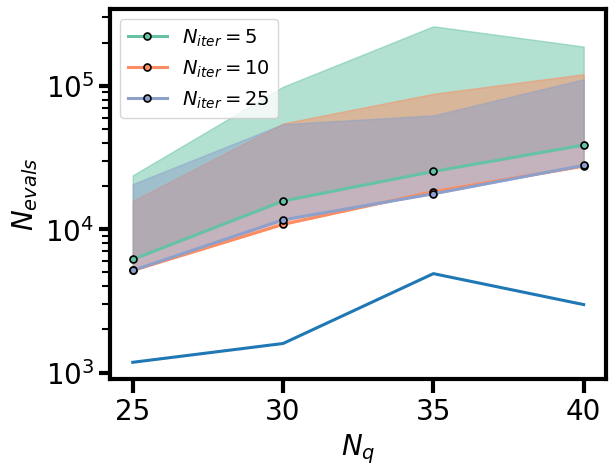

In [558]:
nq = 40
p = 10
colors= plt.get_cmap("Set2")
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()

fig, ax = plt.subplots()
nqs = [25,30,35,40]
Niter = [5,10,25]
for i, p in enumerate(Niter):
    # y = [np.mean([nq*p*results_sa[nq][kk]["SA"][p]["STS"] for kk in results_sa[nq].keys()]) for nq in nqs]
    # ax.plot(nqs, y, marker="^", markeredgecolor="black", color=colors(i), label=f"SA sweeps={p}")
    y = [np.mean([nq*p*results_tabu[nq][kk]["TABU"][p]["STS"] for kk in results_tabu[nq].keys()]) for nq in nqs]
    y_max = [np.max([nq*p*results_tabu[nq][kk]["TABU"][p]["STS"] for kk in results_tabu[nq].keys()]) for nq in nqs]
    ax.fill_between(nqs, y, y_max, color=colors(i), alpha=0.5)

    ax.plot(nqs, y, marker="o", markeredgecolor="black", color=colors(i), label=r"$N_{iter}=$" +f"{p}")
    
    ax.set_ylabel(r"$N_{evals}$")
    ax.set_xlabel(r"$N_q$")
plt.plot(nqs, [p * np.mean([np.ceil(np.log(1-0.99)/np.log(1-results_lrqaoa[nq][kk]["probability"])) for kk in range(100)]) for nq in nqs])
ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/FC_TABU.pdf", bbox_inches="tight", transparent=True)

In [551]:
results_lrqaoa = np.load("/Users/alejomonbar/Documents/GitHub/TheMagicSchedule/Data/WMaxCut_res_TTS_new.npy", allow_pickle=True).item()

Nq:20, sweeps:10, iters:25
Nq:25, sweeps:10, iters:25
Nq:30, sweeps:10, iters:25
Nq:35, sweeps:10, iters:25
Nq:40, sweeps:10, iters:25
name: SA eta: -0.10331556758233394, C: 7.534033126375619, error: 0.014914790772571723
name: TABU eta: -0.11145160227076019, C: 5.528525476486662, error: 0.009215589708251442
name: LR-QAOA eta: -0.09662755740446184, C: 7.535613823070242, error: 0.0070707813852249985
name: LR-QAOA-100 eta: -0.054742019315122736, C: 8.474944990991268, error: 0.03528443318484807


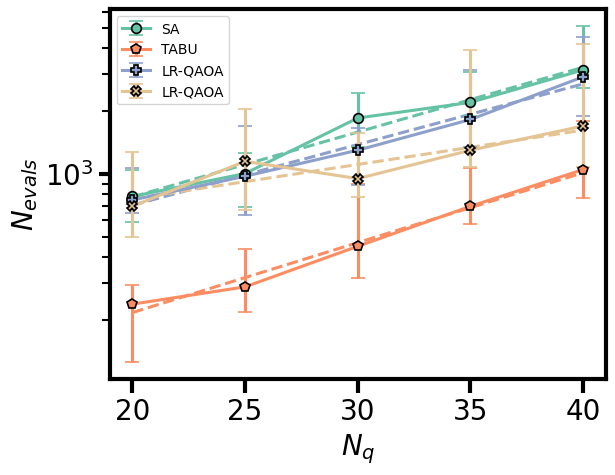

In [737]:
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
hard_problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots()
y_sa = []
y_tabu = []
y_lrqaoa = []
y_cplex = []
probability_qaoa = []
y_lrqaoa100 = []
nqs = [20,25,30,35,40]
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
for nq in nqs:
    arg_sort = arg_sort_dict[nq]
    sweeps_list = [5,8,10,15,20,25,100]
    sweeps_list = [10]
    best_sweep = np.argmin([np.mean([sweeps*results_sa[nq][kk]["SA"][sweeps]["STS"] for kk in arg_sort]) for sweeps in sweeps_list])
    sweeps = sweeps_list[best_sweep]
    y1 = np.array([sweeps*results_sa[nq][kk]["SA"][sweeps]["STS"] for kk in arg_sort])
    y_sa.append(y1)
    y3 = np.array([results_sa[nq][kk]["n_iterations_cplex"] for kk in arg_sort])
    y_cplex.append(y3)
    iters_list = [5,10,15,20,25,100]
    iters_list = [25]
    best_iter = np.argmin([np.mean([iters*results_tabu[nq][kk]["TABU"][iters]["STS"] for kk in arg_sort]) for iters in iters_list])
    iters = iters_list[best_iter]
    y2 = np.array([iters*results_tabu[nq][kk]["TABU"][iters]["STS"] for kk in arg_sort])
    y_tabu.append(y2)
    # if nq not in [30, 35]:
    #     p = 50
    # elif nq == 20:
    #     p = 25
    # else:
    #     p = 100
    p = 50
    y_lrqaoa.append(np.array([p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in results_lrqaoa[nq].keys()]))
    p = 100
    if nq < 40:
        y_lrqaoa100.append(np.array([p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in results_lrqaoa[nq].keys()]))
    else:
        y_lrqaoa100.append(np.array([p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in [i for i in range(20) if i not in [6,10,16]]] + [p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in range(3)]))
    print(f"Nq:{nq}, sweeps:{sweeps}, iters:{iters}")
    # probability_qaoa.append(np.median([results_lrqaoa[nq][kk]["best"][p]["probability"] for kk in results_lrqaoa[nq].keys()]))
y_sa = np.array(y_sa)
y_tabu = np.array(y_tabu)
y_lrqaoa = np.array(y_lrqaoa)
y_lrqaoa100 = np.array(y_lrqaoa100)
q_sa = np.percentile(y_sa, [25, 50, 75], axis=1)
q_tabu = np.percentile(y_tabu, [25, 50, 75], axis=1)
q_cplex = np.percentile(y_cplex, [25, 50, 75], axis=1)
q_lrqaoa = np.percentile(y_lrqaoa, [25, 50, 75], axis=1)
q_lrqaoa100 = np.percentile(y_lrqaoa100, [25, 50, 75], axis=1)

colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3),"LR-QAOA":colors(2),"LR-QAOA-100":colors(6)}
scaling = {}
for name, y in {"SA":q_sa[1,:], "TABU":q_tabu[1,:], "LR-QAOA":q_lrqaoa[1,:],"LR-QAOA-100":q_lrqaoa100[1,:]}.items():#, "B&B":q_cplex[1,:]
    y_real = np.log2(y)
    x0 = [-0.14, 0.5]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas = sol.x[0]
    Cs = sol.x[1]
    error = sol.fun
    scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
    ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name])
    print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")

ax.errorbar(nqs, q_sa[1,:], [q_sa[1,:]-q_sa[0,:],q_sa[2,:]-q_sa[1,:]], marker="o", markeredgecolor="black", color=colors(0), markersize=7, label=f"SA")
ax.errorbar(nqs, q_tabu[1,:], [q_tabu[1,:]-q_tabu[0,:],q_tabu[2,:]-q_tabu[1,:]], marker="p", markeredgecolor="black", color=colors(1), label="TABU", markersize=7)
# ax.errorbar(nqs, q_cplex[1,:], [q_cplex[1,:]-q_cplex[0,:],q_cplex[2,:]-q_cplex[1,:]], marker="X", markeredgecolor="black", color=colors(3), label="B&B", markersize=7)
ax.errorbar(nqs, q_lrqaoa[1,:], [q_lrqaoa[1,:]-q_lrqaoa[0,:],q_lrqaoa[2,:]-q_lrqaoa[1,:]], marker="P", markeredgecolor="black", color=colors(2), label="LR-QAOA", markersize=7)
ax.errorbar(nqs, q_lrqaoa100[1,:], [q_lrqaoa100[1,:]-q_lrqaoa100[0,:],q_lrqaoa100[2,:]-q_lrqaoa100[1,:]], marker="X", markeredgecolor="black", color=colors(6), label="LR-QAOA", markersize=7)

np.save("./Data/scaling_WMC.npy", scaling)
# y_real = np.log2(probability_qaoa)
# x0 = [0.9, 0.5]
# sol = minimize(fit_eta, x0, args=(nqs, y_real))
# etas = sol.x[0]
# Cs = sol.x[1]
# error = sol.fun
# ax.plot(nqs, [p*np.log(1-0.99)/np.log(1-2**(-etas*(nq) + Cs)) for nq in nqs], linestyle="--", color=colors(2))
# error = np.mean((q_lrqaoa - np.array([p*np.log(1-0.99)/np.log(1-2**(-etas*(nq) + Cs)) for nq in nqs]))/q_lrqaoa)
# print(f"eta: {etas}, error: {error}")
ax.set_ylabel(r"$N_{evals}$")
ax.set_xlabel(r"$N_q$")

ax.set_yscale("log")
ax.legend(fontsize=10)
fig.savefig("./Figures/WMaxCut/N_evals_scale.pdf", bbox_inches="tight", transparent=True)

name: SA eta: -0.14611805318102702, C: -14.568636206621822, error: 0.022968539485564134
name: TABU eta: -0.1670359790616631, C: -17.305825387703806, error: 0.01915862363505371
name: B&B eta: -0.2110203428468686, C: -8.745906091115529, error: 0.2042093097403332


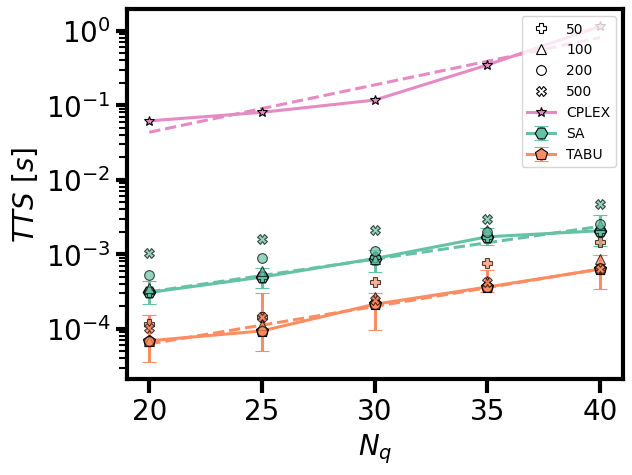

In [21]:
from scipy.optimize import curve_fit

colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
hard_problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots()

nqs = [20,25,30,35,40]
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
nn = 0
markers = {0:"P",1:"^",2:"o",3:"X"}
best = {"SA":defaultdict(int),"TABU":defaultdict(int)}
for iters in [50, 100, 200,500]:
    sweeps = iters
    y_sa = []
    y_tabu = []
    y_cplex = []
    for nq in nqs:
        arg_sort = arg_sort_dict[nq]
        y1 = np.array([results_sa[nq][kk]["SA"][sweeps]["STS"]*results_sa[nq][kk]["SA"][sweeps]["time"] / sum(results_sa[nq][kk]["SA"][sweeps]["results"][:,2]) for kk in arg_sort])
        y_sa.append(y1)
        y3 = np.array([results_sa[nq][kk]["time_cplex_func"] for kk in arg_sort])
        y_cplex.append(y3)
        y2 = np.array([results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2]) for kk in arg_sort])
        y_tabu.append(y2)
    y_sa = np.array(y_sa)
    y_tabu = np.array(y_tabu)
    q_sa = np.percentile(y_sa, [25, 50, 75], axis=1)
    q_tabu = np.percentile(y_tabu, [25, 50, 75], axis=1)
    q_cplex = np.percentile(y_cplex, [25, 50, 75], axis=1)
    colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3)}
    ax.plot(nqs, q_sa[1,:] , marker=markers[nn], markeredgecolor="black", color=colors(0), markersize=7, linewidth=0, alpha=0.7)
    ax.plot(nqs, q_tabu[1,:], marker=markers[nn], markeredgecolor="black", color=colors(1), markersize=7, linewidth=0, alpha=0.7)

    ax.plot([],[],label=iters, marker=markers[nn], markeredgecolor="black", color="white", markersize=7, linewidth=0)
    for i, nq in enumerate(nqs):
        if q_sa[1,i] < np.median(best["SA"][nq]) or np.median(best["SA"][nq]) == 0:
             best["SA"][nq] = q_sa[:,i]

        if q_tabu[1,i] < np.median(best["TABU"][nq]) or np.median(best["TABU"][nq]) == 0:
             best["TABU"][nq] = q_tabu[:,i]
    nn += 1

q_sa = np.array([best["SA"][nq] for nq in nqs]).T
q_tabu = np.array([best["TABU"][nq] for nq in nqs]).T
ax.errorbar(nqs, q_sa[1,:], [q_sa[1,:]-q_sa[0,:],q_sa[2,:]-q_sa[1,:]], marker="H", markeredgecolor="black", color=colors(0), markersize=9, label="SA", zorder=1)
ax.errorbar(nqs, q_tabu[1,:], [q_tabu[1,:]-q_tabu[0,:],q_tabu[2,:]-q_tabu[1,:]], marker="p", markeredgecolor="black", color=colors(1), markersize=9, label="TABU", zorder=1)
ax.plot(nqs, q_cplex[1,:], marker="*", markeredgecolor="black", color=colors(3), markersize=7, label="CPLEX")

scaling = {}
for name, y in {"SA":q_sa[1,:], "TABU":q_tabu[1,:],"B&B":q_cplex[1,:]}.items():#
    y_real = np.log2(y)
    x0 = [-0.14, 0.5]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas = sol.x[0]
    Cs = sol.x[1]
    error = sol.fun
    scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
    ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name], zorder=1)
    print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")
ax.set_ylabel(r"$TTS \ [s]$")
ax.set_xlabel(r"$N_q$")
# ax.set_ylim(2e-5, 7e-3)

# scaling = {}
# colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3),"LR-QAOA":colors(2),"LR-QAOA-100":colors(6)}

# for name, y in {"LR-QAOA":q_lrqaoa[1,:]}.items():#, "B&B":q_cplex[1,:]
#     y_real = np.log2(y)
#     x0 = [-0.14, 0.5]
#     nqs_used = nqs
#     sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
#     etas = sol.x[0]
#     Cs = sol.x[1]
#     error = sol.fun
#     scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
#     ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name])
#     print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")


# ax.plot(nqs, q_lrqaoa50[1,:], marker="P", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.5)
# ax.plot(nqs, q_lrqaoa100[1,:], marker="^", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.5)
# # ax.plot([],[], marker="o", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=0.5, label=50)
# # ax.plot([],[], marker="^", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=0.5, label=100)

# ax.errorbar(nqs, q_lrqaoa[1,:], [q_lrqaoa[1,:]-q_lrqaoa[0,:],q_lrqaoa[2,:]-q_lrqaoa[1,:]], marker="P", markeredgecolor="black", color=colors(2), markersize=7, label="LR-QAOA")


ax.set_yscale("log")
ax.legend(fontsize=10)
fig.savefig("./Figures/WMaxCut/TTS_Heuristics.pdf", bbox_inches="tight", transparent=True)

name: SA eta: -0.14611805318102702, C: -14.568636206621822, error: 0.022968539485564134
name: TABU eta: -0.1670359790616631, C: -17.305825387703806, error: 0.01915862363505371
name: SA eta1: -0.1420768230046135, C1: -14.974423590957379, error: 0.05690315592764909
name: SA eta2: -0.1544230123096874, C2: -14.337177803972487, error: 0.00834061222455643
name: TABU eta1: -0.18395034840040078, C1: -18.627004531799574, error: 0.10075895828058572
name: TABU eta2: -0.12784015610251415, C2: -15.179831744096843, error: 0.042468624610199256


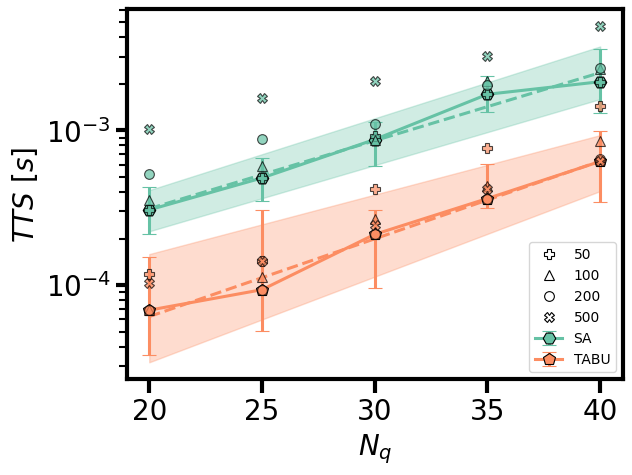

In [42]:
from scipy.optimize import curve_fit

colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
hard_problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots()

nqs = [20,25,30,35,40]
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
nn = 0
markers = {0:"P",1:"^",2:"o",3:"X"}
best = {"SA":defaultdict(int),"TABU":defaultdict(int)}
for iters in [50, 100, 200,500]:
    sweeps = iters
    y_sa = []
    y_tabu = []
    y_cplex = []
    for nq in nqs:
        arg_sort = arg_sort_dict[nq]
        y1 = np.array([results_sa[nq][kk]["SA"][sweeps]["STS"]*results_sa[nq][kk]["SA"][sweeps]["time"] / sum(results_sa[nq][kk]["SA"][sweeps]["results"][:,2]) for kk in arg_sort])
        y_sa.append(y1)
        y3 = np.array([results_sa[nq][kk]["time_cplex_func"] for kk in arg_sort])
        y_cplex.append(y3)
        y2 = np.array([results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2]) for kk in arg_sort])
        y_tabu.append(y2)
    y_sa = np.array(y_sa)
    y_tabu = np.array(y_tabu)
    q_sa = np.percentile(y_sa, [25, 50, 75], axis=1)
    q_tabu = np.percentile(y_tabu, [25, 50, 75], axis=1)
    q_cplex = np.percentile(y_cplex, [25, 50, 75], axis=1)
    colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3)}
    ax.plot(nqs, q_sa[1,:] , marker=markers[nn], markeredgecolor="black", color=colors(0), markersize=7, linewidth=0, alpha=0.7)
    ax.plot(nqs, q_tabu[1,:], marker=markers[nn], markeredgecolor="black", color=colors(1), markersize=7, linewidth=0, alpha=0.7)

    ax.plot([],[],label=iters, marker=markers[nn], markeredgecolor="black", color="white", markersize=7, linewidth=0)
    for i, nq in enumerate(nqs):
        if q_sa[1,i] < np.median(best["SA"][nq]) or np.median(best["SA"][nq]) == 0:
             best["SA"][nq] = q_sa[:,i]

        if q_tabu[1,i] < np.median(best["TABU"][nq]) or np.median(best["TABU"][nq]) == 0:
             best["TABU"][nq] = q_tabu[:,i]
    nn += 1

q_sa = np.array([best["SA"][nq] for nq in nqs]).T
q_tabu = np.array([best["TABU"][nq] for nq in nqs]).T
ax.errorbar(nqs, q_sa[1,:], [q_sa[1,:]-q_sa[0,:],q_sa[2,:]-q_sa[1,:]], marker="H", markeredgecolor="black", color=colors(0), markersize=9, label="SA", zorder=1)
ax.errorbar(nqs, q_tabu[1,:], [q_tabu[1,:]-q_tabu[0,:],q_tabu[2,:]-q_tabu[1,:]], marker="p", markeredgecolor="black", color=colors(1), markersize=9, label="TABU", zorder=1)
# ax.plot(nqs, q_cplex[1,:], marker="*", markeredgecolor="black", color=colors(3), markersize=7, label="CPLEX")

scaling = {}
for name, y in {"SA":q_sa[1,:], "TABU":q_tabu[1,:]}.items():#,"B&B":q_cplex[1,:]
    y_real = np.log2(y)
    x0 = [-0.14, 0.5]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas = sol.x[0]
    Cs = sol.x[1]
    error = sol.fun
    scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
    ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name], zorder=1)
    print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")

scaling = {}
for name, y in {"SA":[q_sa[0,:],q_sa[2,:]], "TABU":[q_tabu[0,:],q_tabu[2,:]]}.items():#,"B&B":q_cplex[1,:]
    y_real = np.log2(y[0])
    x0 = [-0.14, 0.5]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas_1 = sol.x[0]
    Cs_1 = sol.x[1]
    error_1 = sol.fun
    y_real = np.log2(y[1])
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas_2 = sol.x[0]
    Cs_2 = sol.x[1]
    error_2 = sol.fun
    ax.fill_between(nqs, [2**(etas_1*(-nq) + Cs_1) for nq in nqs], [2**(etas_2*(-nq) + Cs_2) for nq in nqs], color=colors_dict[name], alpha=0.3)
    print(f"name: {name} eta1: {etas_1}, C1: {Cs_1}, error: {error_1}")
    print(f"name: {name} eta2: {etas_2}, C2: {Cs_2}, error: {error_2}")
ax.set_ylabel(r"$TTS \ [s]$")
ax.set_xlabel(r"$N_q$")
# ax.set_ylim(2e-5, 7e-3)

# scaling = {}
# colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3),"LR-QAOA":colors(2),"LR-QAOA-100":colors(6)}

# for name, y in {"LR-QAOA":q_lrqaoa[1,:]}.items():#, "B&B":q_cplex[1,:]
#     y_real = np.log2(y)
#     x0 = [-0.14, 0.5]
#     nqs_used = nqs
#     sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
#     etas = sol.x[0]
#     Cs = sol.x[1]
#     error = sol.fun
#     scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
#     ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name])
#     print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")


# ax.plot(nqs, q_lrqaoa50[1,:], marker="P", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.5)
# ax.plot(nqs, q_lrqaoa100[1,:], marker="^", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.5)
# # ax.plot([],[], marker="o", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=0.5, label=50)
# # ax.plot([],[], marker="^", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=0.5, label=100)

# ax.errorbar(nqs, q_lrqaoa[1,:], [q_lrqaoa[1,:]-q_lrqaoa[0,:],q_lrqaoa[2,:]-q_lrqaoa[1,:]], marker="P", markeredgecolor="black", color=colors(2), markersize=7, label="LR-QAOA")


ax.set_yscale("log")
ax.legend(fontsize=10)
fig.savefig("./Figures/WMaxCut/TTS_Heuristics.pdf", bbox_inches="tight", transparent=True)

name: SA eta: -0.14611805318102702, C: -14.568636206621822, error: 0.022968539485564134
name: SA eta: -0.15259649988735927, C: -14.737410249961012, error: [[8.15639873e-09 1.98585472e-07]
 [1.98585472e-07 5.10871964e-06]]
name: TABU eta: -0.1670359790616631, C: -17.305825387703806, error: 0.01915862363505371
name: TABU eta: -0.15149265502387885, C: -16.93389225568912, error: [[6.50817063e-10 1.49858282e-08]
 [1.49858282e-08 3.60435769e-07]]


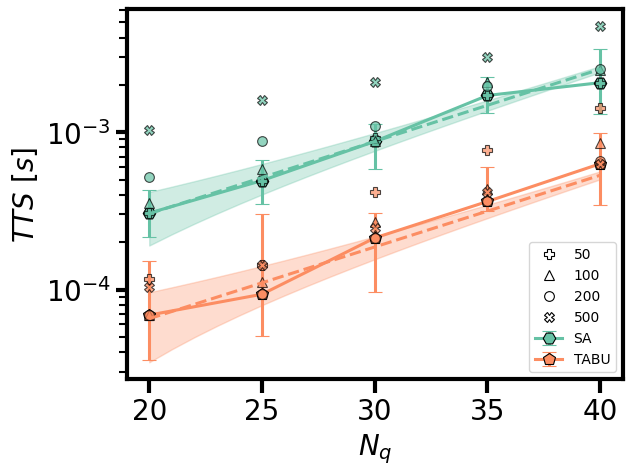

In [ ]:
from scipy.optimize import curve_fit

colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
hard_problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots()

nqs = [20,25,30,35,40]
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
nn = 0
markers = {0:"P",1:"^",2:"o",3:"X"}
best = {"SA":defaultdict(int),"TABU":defaultdict(int)}
for iters in [50, 100, 200,500]:
    sweeps = iters
    y_sa = []
    y_tabu = []
    y_cplex = []
    for nq in nqs:
        arg_sort = arg_sort_dict[nq]
        y1 = np.array([results_sa[nq][kk]["SA"][sweeps]["STS"]*results_sa[nq][kk]["SA"][sweeps]["time"] / sum(results_sa[nq][kk]["SA"][sweeps]["results"][:,2]) for kk in arg_sort])
        y_sa.append(y1)
        y3 = np.array([results_sa[nq][kk]["time_cplex_func"] for kk in arg_sort])
        y_cplex.append(y3)
        y2 = np.array([results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2]) for kk in arg_sort])
        y_tabu.append(y2)
    y_sa = np.array(y_sa)
    y_tabu = np.array(y_tabu)
    q_sa = np.percentile(y_sa, [25, 50, 75], axis=1)
    q_sa_std = np.std(y_sa, axis=1)
    q_tabu = np.percentile(y_tabu, [25, 50, 75], axis=1)
    q_tabu_std = np.std(y_tabu, axis=1)
    q_cplex = np.percentile(y_cplex, [25, 50, 75], axis=1)
    q_cplex_std = np.std(y_cplex, axis=1)
    colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3)}
    ax.plot(nqs, q_sa[1,:] , marker=markers[nn], markeredgecolor="black", color=colors(0), markersize=7, linewidth=0, alpha=0.7)
    ax.plot(nqs, q_tabu[1,:], marker=markers[nn], markeredgecolor="black", color=colors(1), markersize=7, linewidth=0, alpha=0.7)

    ax.plot([],[],label=iters, marker=markers[nn], markeredgecolor="black", color="white", markersize=7, linewidth=0)
    for i, nq in enumerate(nqs):
        if q_sa[1,i] < np.median(best["SA"][nq]) or np.median(best["SA"][nq]) == 0:
             best["SA"][nq] = q_sa[:,i]

        if q_tabu[1,i] < np.median(best["TABU"][nq]) or np.median(best["TABU"][nq]) == 0:
             best["TABU"][nq] = q_tabu[:,i]
    nn += 1

q_sa = np.array([best["SA"][nq] for nq in nqs]).T
q_tabu = np.array([best["TABU"][nq] for nq in nqs]).T


ax.errorbar(nqs, q_sa[1,:], [q_sa[1,:]-q_sa[0,:],q_sa[2,:]-q_sa[1,:]], marker="H", markeredgecolor="black", color=colors(0), markersize=9, label="SA", zorder=1)
ax.errorbar(nqs, q_tabu[1,:], [q_tabu[1,:]-q_tabu[0,:],q_tabu[2,:]-q_tabu[1,:]], marker="p", markeredgecolor="black", color=colors(1), markersize=9, label="TABU", zorder=1)
# ax.plot(nqs, q_cplex[1,:], marker="*", markeredgecolor="black", color=colors(3), markersize=7, label="CPLEX")


q_std = {"SA":q_sa_std, "TABU":q_tabu_std,"B&B":q_cplex_std}

scaling = {}
for name, y in {"SA":q_sa[1,:], "TABU":q_tabu[1,:]}.items():#,"B&B":q_cplex[1,:]
    y_real = np.log2(y)
    x0 = [-0.14, 0.5]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas = sol.x[0]
    Cs = sol.x[1]
    error = sol.fun
    scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
    # ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name], zorder=1)

    def fit_uncertainty(x, func, popt, pcov):
        J = np.array([np.gradient(func(x, *popt), param) for param in popt])  # Jacobian approx
        return np.sqrt(np.einsum("ij,jk,ik->i", J.T, pcov, J.T))
    popt, pcov = curve_fit(eta_func, nqs, y_real, sigma=q_std[name], absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties on parameters
    x_fit = np.arange(min(nqs), max(nqs)+1)
    y_fit = [2**i for i in eta_func(x_fit, *popt)]
    y_uncertainty = fit_uncertainty(x_fit, eta_func, popt, pcov)
    plt.fill_between(x_fit, y_fit - y_uncertainty, y_fit + y_uncertainty,
                 color=colors_dict[name], alpha=0.3)

    # Plot the fit
    ax.plot(x_fit, y_fit, linestyle="--", color=colors_dict[name])
    print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")
    print(f"name: {name} eta: {popt[0]}, C: {popt[1]}, error: {pcov}")
    
ax.set_ylabel(r"$TTS \ [s]$")
ax.set_xlabel(r"$N_q$")
ax.set_yscale("log")
ax.legend(fontsize=10)
fig.savefig("./Figures/WMaxCut/TTS_Heuristics.pdf", bbox_inches="tight", transparent=True)

name: LR-QAOA eta: -0.1075043025225584, C: -15.93638835325013, error: 0.011568357193544437


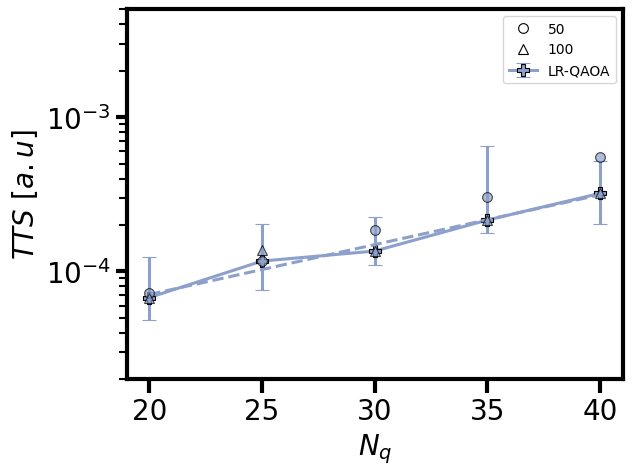

In [57]:
colors= plt.get_cmap("Set2")
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
hard_problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots()
y_lrqaoa = []
y_lrqaoa100 = []
nqs = [20,25,30,35,40]
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
tg = 2.3e-9
best = defaultdict(int)
for nq in nqs:
    p = 50
    y_lrqaoa.append(np.array([tg*(2*nq+2)*p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in results_lrqaoa[nq].keys()]))
    p = 100
    if nq < 40:
        y_lrqaoa100.append(np.array([tg*(2*nq+2)*p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in results_lrqaoa[nq].keys()]))
    else:
        y_lrqaoa100.append(np.array([tg*(2*nq+2)*p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in range(20)]))
    
y_lrqaoa = np.array(y_lrqaoa)
y_lrqaoa100 = np.array(y_lrqaoa100)

q_lrqaoa50 = np.percentile(y_lrqaoa, [25, 50, 75], axis=1)
q_lrqaoa100 = np.percentile(y_lrqaoa100, [25, 50, 75], axis=1)
for i, nq in enumerate(nqs):
    if q_lrqaoa50[1,i] < np.median(best[nq]) or np.median(best[nq]) == 0:
            best[nq] = q_lrqaoa50[:,i]
    if q_lrqaoa100[1,i] < np.median(best[nq]) or np.median(best[nq]) == 0:
        best[nq] = q_lrqaoa100[:,i]

q_lrqaoa = np.array([best[nq] for nq in nqs]).T

colors_dict = {"SA":colors(0),"TABU":colors(1),"B&B":colors(3),"LR-QAOA":colors(2),"LR-QAOA-100":colors(6)}
scaling = {}
for name, y in {"LR-QAOA":q_lrqaoa[1,:]}.items():#, "B&B":q_cplex[1,:]
    y_real = np.log2(y)
    x0 = [-0.14, -10]
    nqs_used = nqs
    sol = minimize(fit_eta, x0, args=(nqs_used, y_real))
    etas = sol.x[0]
    Cs = sol.x[1]
    error = sol.fun
    scaling[name] = {"eta":etas, "Cs":Cs, "error":error}
    ax.plot(nqs, [2**(etas*(-nq) + Cs) for nq in nqs], linestyle="--", color=colors_dict[name])
    print(f"name: {name} eta: {etas}, C: {Cs}, error: {error}")

# ax.errorbar(nqs, q_cplex[1,:], [q_cplex[1,:]-q_cplex[0,:],q_cplex[2,:]-q_cplex[1,:]], marker="X", markeredgecolor="black", color=colors(3), label="B&B", markersize=7)
ax.plot(nqs, q_lrqaoa50[1,:], marker="o", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.7)
ax.plot(nqs, q_lrqaoa100[1,:], marker="^", markeredgecolor="black", color=colors(2), markersize=7, linewidth=0, alpha=0.7)
ax.plot([],[], marker="o", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=1, label=50)
ax.plot([],[], marker="^", markeredgecolor="black", color="white", markersize=7, linewidth=0, alpha=1, label=100)

ax.errorbar(nqs, q_lrqaoa[1,:], [q_lrqaoa[1,:]-q_lrqaoa[0,:],q_lrqaoa[2,:]-q_lrqaoa[1,:]], marker="P", markeredgecolor="black", color=colors(2), markersize=9, label="LR-QAOA", zorder=1)

ax.set_ylabel(r"$TTS \ [a.u]$")
ax.set_xlabel(r"$N_q$")

ax.set_yscale("log")
ax.legend(fontsize=10)
ax.set_ylim(2e-5, 5e-3)
fig.savefig("./Figures/WMaxCut/TTS_LRQAOA.pdf", bbox_inches="tight", transparent=True)

Correlation : 20 : 0.6654080145646728
Correlation : 25 : 0.6647393438131812
Correlation : 30 : 0.5555167246992703
Correlation : 35 : 0.8696243969827291
Correlation : 40 : 0.7656792359725869
Correlation Mean : 0.7041935432064881


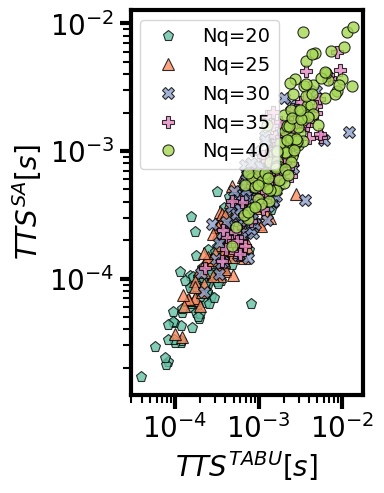

In [974]:
nq = 40
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()

markers = {20:"p", 25:"^", 30:"X", 35:"P", 40:"o"}
fig, ax = plt.subplots(figsize=(3,5))
sweeps = 10
iters = 10
PCC = []
for i, nq in enumerate([20,25,30,35,40]):
    y = [results_sa[nq][kk]["SA"][sweeps]["STS"]*results_sa[nq][kk]["SA"][sweeps]["time"] / sum(results_sa[nq][kk]["SA"][sweeps]["results"][:,2]) for kk in results_sa[nq].keys()]
    x = [results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2])  for kk in results_tabu[nq].keys()]
    ax.plot(x, y, linewidth=0, markeredgecolor="black", color=colors(i), label=f"Nq={nq}", marker=markers[nq], markersize=8, alpha=0.8)
    PCC.append(np.corrcoef(x,y)[0,1])
    print(f"Correlation : {nq} : {PCC[-1]}")
print(f"Correlation Mean : {np.mean(PCC)}")
ax.set_xlabel(r"$TTS^{TABU} [s]$")
ax.set_ylabel(r"$TTS^{SA} [s]$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/SA_vs_TABU_TTS.pdf", bbox_inches="tight", transparent=True)

Correlation : 20 : -0.07448845735479623
Correlation : 25 : 0.1352852351841588
Correlation : 30 : 0.07633536075648245
Correlation : 35 : 0.5628012030743073
Correlation : 40 : 0.4394547561426607
Correlation Mean : 0.2278776195605626


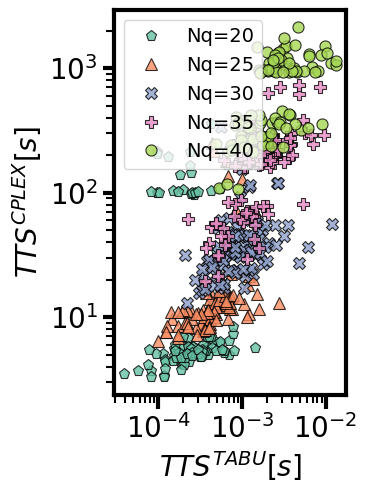

In [976]:
nq = 40
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()

markers = {20:"p", 25:"^", 30:"X", 35:"P", 40:"o"}
fig, ax = plt.subplots(figsize=(3,5))
sweeps = 10
iters = 10
PCC = []
for i, nq in enumerate([20,25,30,35,40]):
    y = [results_sa[nq][kk]["time_cplex"] for kk in results_sa[nq].keys()]
    x = [results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2])  for kk in results_tabu[nq].keys()]
    ax.plot(x, y, linewidth=0, markeredgecolor="black", color=colors(i), label=f"Nq={nq}", marker=markers[nq], markersize=8, alpha=0.8)
    PCC.append(np.corrcoef(x,y)[0,1])
    print(f"Correlation : {nq} : {PCC[-1]}")
print(f"Correlation Mean : {np.mean(PCC)}")
ax.set_xlabel(r"$TTS^{TABU} [s]$")
ax.set_ylabel(r"$TTS^{CPLEX} [s]$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.savefig("./Figures/WMaxCut/CPLEX_vs_TABU_TTS.pdf", bbox_inches="tight", transparent=True)

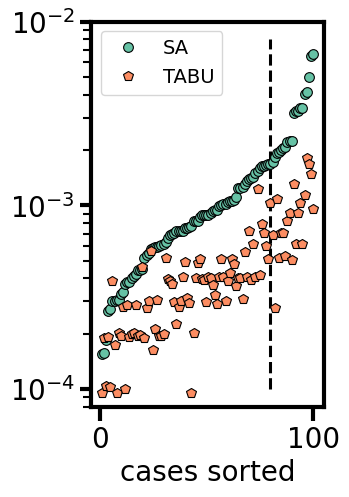

In [969]:
nq = 40
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
results_lrqaoa = np.load(f"./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
fig, ax = plt.subplots(figsize=(3,5))
nq = 40
sweeps = 50
t2q = 2.5e-9
y1 = np.array([results_sa[nq][kk]["SA"][sweeps]["STS"]*results_sa[nq][kk]["SA"][sweeps]["time"] / sum(results_sa[nq][kk]["SA"][sweeps]["results"][:,2]) for kk in results_sa[nq].keys()])
iters = 200
y2 = np.array([results_tabu[nq][kk]["TABU"][iters]["STS"]*results_tabu[nq][kk]["TABU"][iters]["time"] / sum(results_tabu[nq][kk]["TABU"][iters]["results"][:,2]) for kk in results_tabu[nq].keys()])
arg_sort = np.argsort([results_sa[nq][kk]["SA"][50]["STS"] for kk in results_sa[nq].keys()])
arg_sort = np.argsort(y1)
y3 = np.array([t2q*nq*p*results_lrqaoa[nq][kk]["best"][p]["STS"] for kk in results_lrqaoa[nq].keys()])
ax.vlines(80,1e-4,8e-3, color="black", linestyle="--")

ax.plot(range(1,len(arg_sort)+1), y1[arg_sort], marker="o", linewidth=0, markeredgecolor="black", color=colors(0), markersize=7, label="SA")
ax.plot(range(1,len(arg_sort)+1), y2[arg_sort], marker="p", linewidth=0, markeredgecolor="black", color=colors(1), label="TABU", markersize=7)
# ax.plot(range(80,100), y3, marker="X", linewidth=0, markeredgecolor="black", color=colors(2), label="LR-QAOA", markersize=7)
# ax.set_ylabel(r"$TTS \ [s] $")
ax.set_xlabel("cases sorted")
# ax.set_xticks([1,5,10,15,20])
ax.set_yscale("log")
ax.legend()
ax.set_ylim(8e-5,1e-2)
fig.savefig(f"./Figures/WMaxCut/TTS_SA_TABU_{nq}.pdf", bbox_inches="tight", transparent=True)